# An overview to input datasets

LUTO-2 is version two of the Land-Use Trade-Offs model. The model predicts future spatial land-use distributions based on an economic cost-minimisation or profit-maximization logic under various constraints. Although it is a spatial model, LUTO-2 rearranges all the input data from 2D-map format into a 1D-array representation to save memory and reduce running time, making it difficult for users to intuitively understand what happened within each process. This converts the 1D-array back to its original 2D format and visulizes how land-use change is driven by the various constrains.

```{note}
LUTO-2 is capable of running land-use change for Australia at a ~1x1 square kilometer scale, but this chapter will use a setting that specifies `RESFACTOR=5` to reduce processing time. Essentially, this resfactor means we are only using the centroid cell out of each 5*5 square matrix to run the model.
```

Here we run LUTO-2 model to get necessary data variables for illustrating how the model works. LUTO converts all input data into `numpy.ndarray` for every processing, but in the manual we use `xarray.DataArray` for more easier data manupilation. The main advantage of `xarray` over `numpy` is that it can lable high-dimension array (usually being called as a 'Tensor' or 'nd-Matrices') with sensible names.

In [40]:
# HIDDEN

'''
Here are the code to run LUTO first, so that we can have the variables and objects required for illustration in the notebook.
'''

# Reload all modules before excuting each cell, so that we can modify the imported custom functions on-the-fly without rerun the whole model.
%load_ext autoreload
%autoreload 2


# Imports
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9
from mizani.formatters import scientific_format



# cd to the root folder of LUTO project
os.chdir('N:/LUF-Modelling/LUTO2_JZ/luto-2.0')
from luto.tools.Manual_jupyter_books.helpers import map_to_4band, mrj_to_xr, arr_to_xr, map_to_plot
from luto.economics.agricultural.quantity import get_quantity_matrices
from luto.economics.agricultural.water import get_wreq_matrices
from luto.tools.Manual_jupyter_books.helpers.parameters import legend_params


# # Run LUTO
# import luto.simulation as sim
# data = sim.load_data()
# sim.run(data=data, base=2010, target=2050)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Before get our head into the amazing LUTO world, please keep in mind that this manual tris to explain how LUTO works in the most intuitive way. That means sometime we may loss technical depth or skip over certain complexities. If you are keen to understand how exactly this model works, we encourage you to look at the source code and  and delve into the tech/data manul provided under the `/docs`. 

## National Land-use Map of Australia for 2010

LUTO-2 uses the national land-use map of 2010 as the starting point. The map is downloaded from [DAFF](https://www.agriculture.gov.au/abares/aclump/land-use/land-use-mapping) and has several different classification schemes. Because LUTO-2 is an agricultural model, we exclude water and intensive uses (urban built-ups, commercial uses, etc.) from the modeling and created a land-use classification based on the 'PRIMARY_V7' schema of DAFF and a profit map provided by CSIRO. The final land-use map is classified as shown in the below table.

| Code | Description                | Code | Description              | Code | Description                  | Code | Description                 |
|------|----------------------------|------|--------------------------|------|------------------------------|------|-----------------------------|
| -1   | Non Agricultural and       | 7    | Grapes                   | 15   | Sheep - natural land         | 23   | Unallocated - natural land  |
| 0    | Apples                     | 8    | Hay                      | 16   | Stone fruit                  | 24   | Vegetables                  |
| 1    | Beef - modified land       | 9    | Nuts                     | 17   | Sugar                        | 25   | Winter cereals              |
| 2    | Beef - natural land        | 10   | Other non-cereal crops   | 18   | Summer cereals               | 26   | Winter legumes              |
| 3    | Citrus                     | 11   | Pears                    | 19   | Summer legumes               | 27   | Winter oilseeds             |
| 4    | Cotton                     | 12   | Plantation fruit         | 20   | Summer oilseeds              |                                    |
| 5    | Dairy - modified land      | 13   | Rice                     | 21   | Tropical stone fruit         |                                    |
| 6    | Dairy - natural land       | 14   | Sheep - modified land    | 22   | Unallocated - modified land  |                                    |



It is overwhelming to consider all 28 agricultural land-use for illustration. Instead, let's only map the sptail distribution of `Winter cereals` under minimized-cost/maximized-profit drives given various constraints. Referring to table above, we know that the code of 25 is winter cereal. We will use this value to extract the map of winter cereal.

In [52]:
# HIDDEN

# Define year, lu_code
year_begin = 2010
year_target = 2050
lu_code = 25 # Winter cereals
lu_desc = data.AGRICULTURAL_LANDUSES[lu_code]

# Parameters to save xarray
output_dir = 'luto/tools/Manual_jupyter_books/outputs'
encoding={'data': {"compression": "gzip", "compression_opts": 9,  "dtype": 'float32'}}

# Get the lumap
lumap = mrj_to_xr(data, data.ag_dvars[year_begin])
lu_arr_dry = lumap.sel(lm='dry', lu=lu_desc)
lu_arr_irr = lumap.sel(lm='irr', lu=lu_desc)

lu_mask = arr_to_xr(data, np.ones_like(lumap)) == 1
lu_area = arr_to_xr(data, data.REAL_AREA)


# Save to disk
lu_arr_dry.name = 'data'
lu_arr_irr.name = 'data'

lu_arr_dry.to_netcdf(f'{output_dir}/lu_arr_dry.nc', engine='h5netcdf', encoding=encoding)
lu_arr_irr.to_netcdf(f'{output_dir}/lu_arr_irr.nc', engine='h5netcdf', encoding=encoding)

 It is important to acknowledge that the same land-use under different water supply management (`dry` or `irrigated`) requires significantly different water consumption and economic investment, which ultimately leads to very different yields. To account for this, LUTO-2 introduces a dry/irrigation map that further classifies agricultural land-use into dry land or irrigated land. In this manual, we will split winter cereals into their corresponding dry and irrigated parts. Additionally, input data such as 'water requirement,' 'GHG release,' and 'cost' are provided with a water supply attribution.



If you have a pair of eagle eyes, you can find that only a very small number of irradiated winter cereal cells are scattered in Victoria.

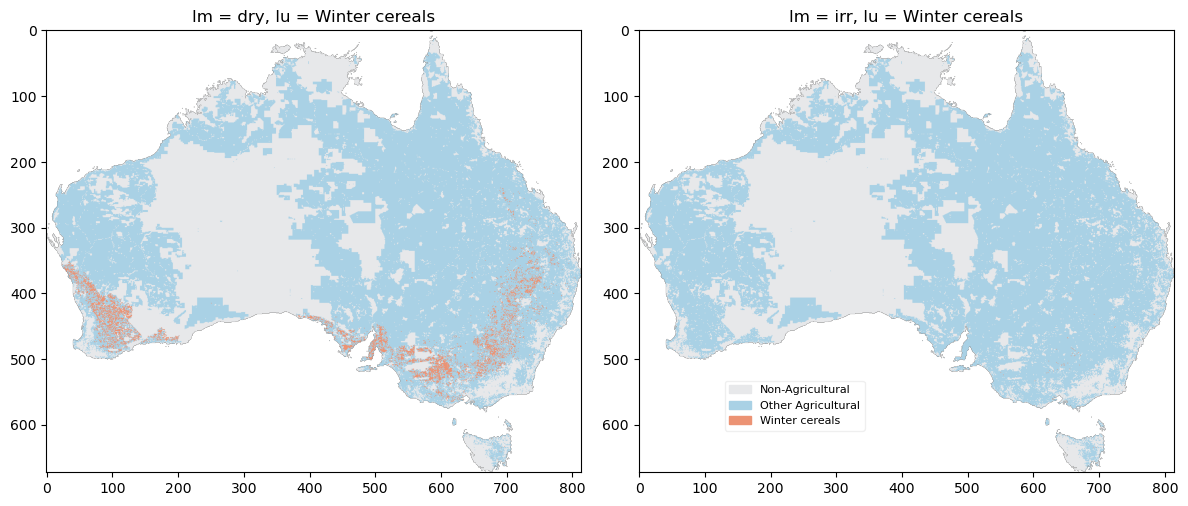

In [7]:
# HIDDEN

# Get colors/names for pixcels with values of [-1, 0, 1]
colors = [
    (231, 232, 234, 255), # Light grey
    (169, 209, 229, 255), # Light blue
    (236, 147, 116, 255)  # Light red
]

cell_names = [
    'Non-Agricultural', 
    'Other Agricultural', 
    'Winter cereals'
]

# Create a figure and a set of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first map (dry) on the first axis
map_to_plot(lu_arr_dry, colors, cell_names, legend_params, ax=axs[0])
axs[0].set_title(f'lm = dry, lu = {lu_desc}')

# Plot the second map (irr) on the second axis
map_to_plot(lu_arr_irr, colors, cell_names, legend_params, ax=axs[1])
axs[1].set_title(f'lm = irr, lu = {lu_desc}')

# Optionally, adjust the layout
plt.tight_layout()

# Show the combined plots
plt.show()

Before diving into input data, please keep in mind our objective: find the sptail distribution for winter cereal that is the most cost-minimized/profit-maximized, as well as meeting constraints in water use and GHG emissions.

## Demand

As an agricultural model, the first target to meet is the food demand. The demand data (tones) is a `pandas.DataFrame` lives in the `data.DEMAND_DATA` variable. We can see that the index of the demand dataframe is commodities, the column is a 2-level column that represents demand compositions and years.

In [7]:
# HIDDEN
data.DEMAND_DATA

DOMESTIC                                                                                                                                                                                                                                                                                                                                                                                                                                  \
YEAR                              2010            2011            2012            2013            2014            2015            2016            2017            2018            2019            2020            2021            2022            2023            2024            2025            2026            2027            2028            2029            2030            2031            2032            2033            2034            2035            2036   
COMMODITY                                                                                                                                                                                                                                                                                                                                                                                                                                                                
apples                    203,708.7139    228,252.0934    220,834.0457    219,436.7185    220,861.4305    222,009.1024    223,094.2814    224,097.1645    225,019.9145    229,481.5501    230,966.0091    232,231.3345    233,534.1534    234,874.9881    236,254.3758    237,672.8629    238,775.0516    239,913.5179    241,088.6420    242,300.7978    243,550.3521    244,547.0916    245,579.1384    246,646.7020    247,749.9816    248,889.1668    249,871.1606   
aquaculture                84,325.6736     88,475.6272     84,073.4230     93,863.0572     92,471.6239     94,551.7902     96,709.9873     98,823.2165    100,888.7726    105,059.5298    107,489.6377    109,941.7799    112,421.1738    114,927.7703    117,461.5649    120,022.5943    122,491.3890    124,982.2462    127,495.2241    130,030.4110    132,587.9230    135,103.7672    137,639.1005    140,194.0559    142,768.7871    145,363.4672    147,936.1114   
beef lexp                       0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000          0.0000   
beef meat               1,042,569.7153  1,180,503.0272  1,030,967.1872    999,184.8582  1,024,341.9924  1,025,573.3298  1,026,448.4555  1,026,884.0841  1,026,898.5652  1,042,947.8891  1,045,344.2369  1,046,690.0688  1,048,153.0015  1,049,736.5562  1,051,444.1778  1,053,279.2182  1,053,674.1736  1,054,199.0121  1,054,856.1380  1,055,647.8141  1,056,576.1614  1,056,387.9582  1,056,338.8828  1,056,430.1528  1,056,662.8573  1,057,037.9651  1,056,738.9352   
chicken                   870,929.5029    994,709.7131  1,016,384.5109  1,043,175.8359  1,041,406.5664  1,070,653.8177  1,099,189.0498  1,126,962.1359  1,154,015.6623  1,199,285.0486  1,229,146.1802  1,257,707.4253  1,286,342.0223  1,315,079.3951  1,343,944.6231  1,372,959.2224  1,400,054.6846  1,427,250.0890  1,454,559.0285  1,481,993.4522  1,509,563.9750  1,535,455.6962  1,561,437.7668  1,587,517.6875  1,613,702.3624  1,639,998.2158  1,665,123.2971   
citrus                    454,333.9626    478,132.6221    453,502.9576    476,896.8404    477,678.1278    483,749.8030    489,691.9230    495,456.3275    501,042.6048    514,560.5766    521,461.6639    527,875.5090    534,377.9803    540,970.7211    547,655.4405    554,433.9015    560,472.3937    566,588.7765    572,784.5153    579,061.0840    585,419.9599    591,

```{note}
The demand compositions include 'DOMESTIC', 'EXPORTS', 'IMPORTS', 'FEED', 'PRODUCTION', and the 'PRODUCTION' record is the demand data that LUTO needs to meet. The relationship between these compositions is:  
`PRODUCTION` = `DOMESTIC` + `EXPORTS` + `FEED` - `IMPORTS`
```

```{note}
If you have a close look at the `COMMODITY` index, you can find that index items are all lower-case. In addition, there are 30 commodities in total (remember there are only 28 land-uses). Why lower case and 2 more commodities? Carefully observe the table below that shows the mismatched land-use and commodities. Think of the reason by yourself; the answer is in the below explanation.
```

| Land-use                      | Comodity                          |
|-------------------------------|-----------------------------------|
| Beef - modified land          | beef lexp, beef meat              |
| Beef - natural land           | beef lexp, beef meat              |
| Dairy - modified land         | dairy                             |
| Dairy - natural land          | dairy                             |
| Unallocated - modified land   | -                                 |
| Unallocated - natural land    | -                                 |
| Sheep - modified land         | beef lexp, sheep meat, sheep wool |
| Sheep - natural land          | beef lexp, sheep meat, sheep wool |
| -                             | aquaculture                       |
| -                             | chicken                           |
| -                             | eggs                              |
| -                             | pork                              |

The reason for "why 2 more commodities" is that there are two land uses (unallocated land) that do not produce any commodities, and 4 commodities (aquculture, chicken, egg, and pork) cannot be produced from any land use. The math is simple, but it leads to another problem: If there are 4 additional commodities that cannot be produced by any land use, how can LUTO meet these demands by rearranging land use distributions? The answer is that LUTO assumes that the demand for these 4 commodities will be met in the target year, and LUTO arranges land-use to mitigate their environmental impacts. For example, to meet the demand for eggs in 2030, a total of 500 kt of GHG were emitted. LUTO will then try to plant more trees to sequestrate these carbons. In this way, LUTO considers both on-land (commodities produced directly from land) and off-land (commodities produced from cages or factories) commodities, making itself a more complete agricutural model.

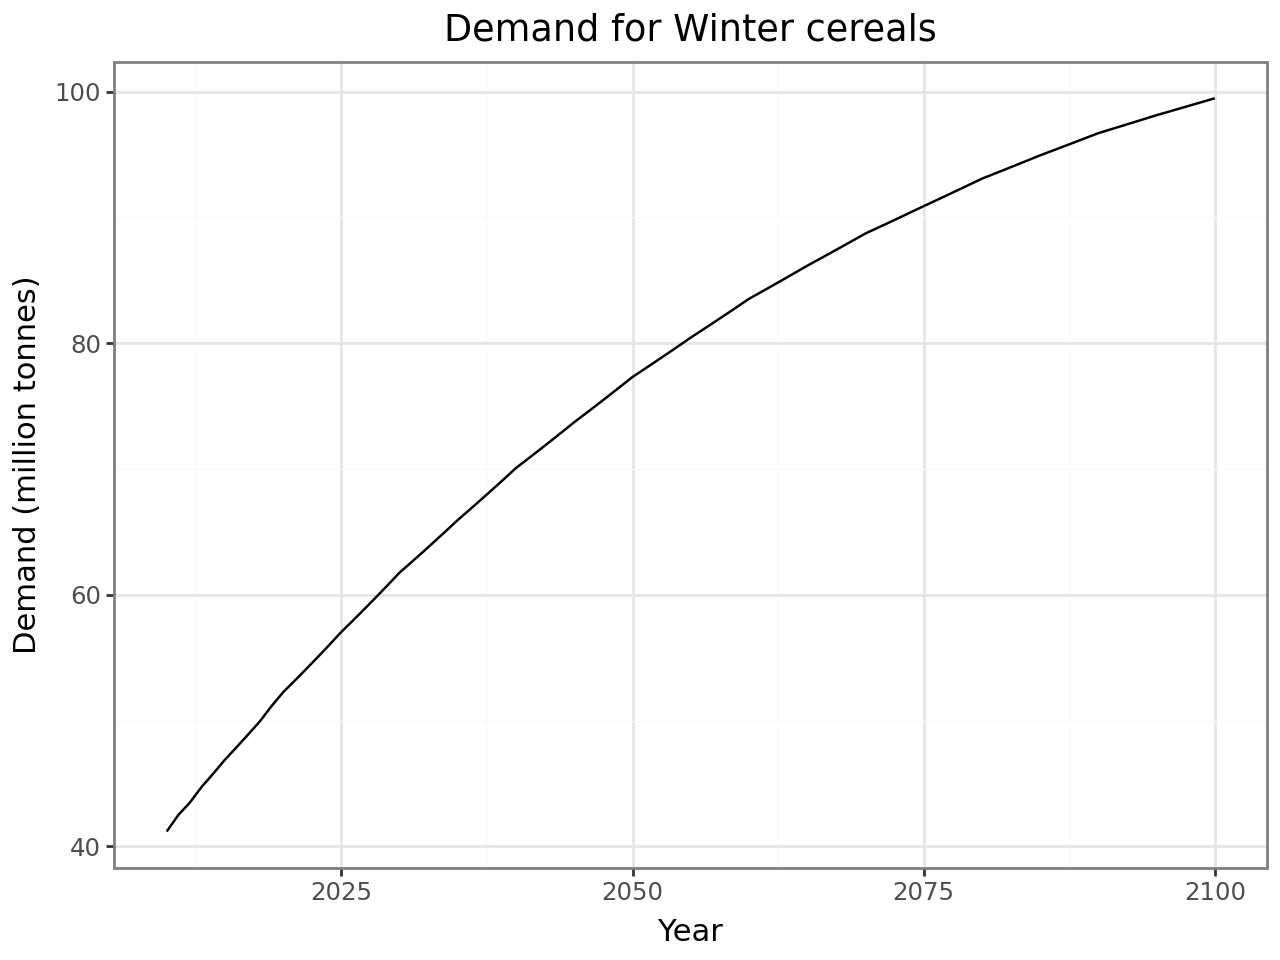

In [45]:
# HIDDEN

# Get the demand data
demand_df = data.DEMAND_DATA.unstack().reset_index()
demand_df.columns = ['Type', 'Year', 'Commodity', 'Value']


# Get the demand for the selected land use
demand_lu = demand_df.query('Type == "PRODUCTION" and Commodity == @lu_desc.lower()')


# Plot the demand
fig = (p9.ggplot(demand_lu, p9.aes(x='Year', y='Value'))
    + p9.geom_line()
    + p9.theme_bw()
    + p9.labs(title=f'Demand for {lu_desc}', x='Year', y='Demand (million tonnes)')
    + p9.scale_y_continuous(labels=lambda f: [f'{x / 1e6:.0f}' for x in f])
    )

fig

Now we can simply query the demand data for year 2050 and we will get target to meet.

In [46]:
# HIDDEN
# Get the demand for the target year
demand_vol = demand_lu.query('Year == @year_target')['Value'].values[0] / 1e6  # Million tonnes

print(f'The demand for {lu_desc} in {year_target} is {demand_vol:.2f} million tonnes.')

The demand for Winter cereals in 2050 is 77.31 million tonnes.


::::{important}
Diets, exports, and the economy will change the demand for food, so it is a good to consider these factors. Luckily, LUTO has provided us with some switches to choose the scenario we are interested. For example, if we want to use the demand with halved food waste, we just need to change the `WASTE` parameter in `luto.settings` to `0.5`.
::::

| Parameter         | Values                          | Note                                                                                                                            |
|-------------------|---------------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| SCENARIO          | SSP1, SSP2, SSP3, SSP4, SSP5    |                                                                                                                                 |
| DIET_DOM          | BAU, FLX, VEG, VGN              | 'BAU', 'FLX', 'VEG', 'VGN' - domestic diets in Australia                                                                        |
| DIET_GLOB         | BAU, FLX, VEG, VGN              | 'BAU', 'FLX', 'VEG', 'VGN' - global diets                                                                                       |
| CONVERGENCE       | 2050, 2100                      | 2050 or 2100 - date at which dietary transformation is completed (velocity of transformation)                                   |
| IMPORT_TREND      | Static, Trend                   | 'Static' assumes 2010 shares of imports for each commodity or 'Trend' follows historical rate of change in shares of imports    |
| WASTE             | 0.5, 1.0                        | 1 for full waste, 0.5 for half waste                                                                                            |
| FEED_EFFICIENCY   | BAU, High                       | 'BAU' or 'High'                                                                                                                 |




In [47]:
# HIDDEN
dd = pd.read_hdf(os.path.join('input', 'demand_projections.h5') )
dd_long = dd['PRODUCTION'].stack().reset_index().rename(columns={0: 'DEMAND_TONNES'})
dd_long

,SCENARIO,DIET_DOM,DIET_GLOB,CONVERGENCE,IMPORT_TREND,WASTE,FEED_EFFICIENCY,COMMODITY,YEAR,DEMAND_TONNES
0,SSP1,BAU,BAU,2050,Static,0.5000,BAU,apples,2010,"262,358.1418"
1,SSP1,BAU,BAU,2050,Static,0.5000,BAU,apples,2011,"284,784.3501"
2,SSP1,BAU,BAU,2050,Static,0.5000,BAU,apples,2012,"276,239.4804"
3,SSP1,BAU,BAU,2050,Static,0.5000,BAU,apples,2013,"273,533.2604"
4,SSP1,BAU,BAU,2050,Static,0.5000,BAU,apples,2014,"273,515.7308"
...,...,...,...,...,...,...,...,...,...,...
3494395,SSP5,VGN,VGN,2100,Trend,1.0000,High,winter oilseeds,2096,"5,238,019.6856"
3494396,SSP5,VGN,VGN,2100,Trend,1.0000,High,winter oilseeds,2097,"5,208,158.8774"
3494397,SSP5,VGN,VGN,2100,Trend,1.0000,High,winter oilseeds,2098,"5,177,607.6643"
3494398,SSP5,VGN,VGN,2100,Trend,1.0000,High,winter oilseeds,2099,"5,146,356.9056"


## Productivity

In [8]:
'''
The acronyms for the columns in the `AGEC_CROPS` dataset are as follows:

AC - Area cost ($/ha)
FDC - Fixed depreciation cost ($/ha)
FLC - Fixed labour cost ($/ha)
FOC - Fixed operating cost ($/ha)
P1 - Price of output 1 ($/t); For crops, this is the only variable for price
QC - Quantity cost ($/t)
WR - Water requirement (t/ha)
WP - Water price ($/t)


There are additional columns for the `AGEC_LVSTK` data:

F1 - Fraction of herd to produce <Meat for `BEEF` and `SHEEP`> and <milk for `DAIRY`>
F2 - Fraction of herd to produce `WOOL` for `SHEEP`
F3 - Fraction of herd as `Live export` for `BEEF` and `SHEEP`

Q1 - Quantity of output 1 (tonnes/head); 
Q2 - Quantity of output 2 (tonnes/head);
Q3 - Quantity of output 3 (animal weight tonnes/head);

P1 - Price of output 1 ($/t); ($/tonne of meat for `BEEF` and `SHEEP`, $/tonne of milk for `DAIRY`)
P2 - Price of output 2 ($/t); ($/tonne of wool for `SHEEP`)
P3 - Price of output 3 ($/t); ($/tonne of live export for `BEEF` and `SHEEP`)

WR_DRN - Water requirement (t/head);
WR_IRR - Water requirement (t/ha); This only applies to `irrigated` livestock
'''

'\nThe acronyms for the columns in the `AGEC_CROPS` dataset are as follows:\n\nAC - Area cost ($/ha)\nFDC - Fixed depreciation cost ($/ha)\nFLC - Fixed labour cost ($/ha)\nFOC - Fixed operating cost ($/ha)\nP1 - Price of output 1 ($/t); For crops, this is the only variable for price\nQC - Quantity cost ($/t)\nWR - Water requirement (t/ha)\nWP - Water price ($/t)\n\n\nThere are additional columns for the `AGEC_LVSTK` data:\n\nF1 - Fraction of herd to produce <Meat for `BEEF` and `SHEEP`> and <milk for `DAIRY`>\nF2 - Fraction of herd to produce `WOOL` for `SHEEP`\nF3 - Fraction of herd as `Live export` for `BEEF` and `SHEEP`\n\nQ1 - Quantity of output 1 (tonnes/head); \nQ2 - Quantity of output 2 (tonnes/head);\nQ3 - Quantity of output 3 (animal weight tonnes/head);\n\nP1 - Price of output 1 ($/t); ($/tonne of meat for `BEEF` and `SHEEP`, $/tonne of milk for `DAIRY`)\nP2 - Price of output 2 ($/t); ($/tonne of wool for `SHEEP`)\nP3 - Price of output 3 ($/t); ($/tonne of live export for `BE

<b>AGEC_CROPS Dataset</b>

| Acronym | Description                                  |
|---------|----------------------------------------------|
| AC      | Area cost ($/ha)                            |
| FDC     | Fixed depreciation cost ($/ha)              |
| FLC     | Fixed labour cost ($/ha)                    |
| FOC     | Fixed operating cost ($/ha)                 |
| P1      | Price of output 1 ($/t)                     |
| QC      | Quantity cost ($/t)                         |
| WR      | Water requirement (t/ha)                    |
| WP      | Water price ($/t)                           |

<b>AGEC_LVSTK Dataset</b>

| Acronym | Description                                      |
|---------|--------------------------------------------------|
| F1      | Fraction of herd to produce <Meat for `BEEF` and `SHEEP`> and <milk for `DAIRY`> |
| F2      | Fraction of herd to produce `WOOL` for `SHEEP`  |
| F3      | Fraction of herd as `Live export` for `BEEF` and `SHEEP` |
| Q1      | Quantity of output 1 (tonnes/head)              |
| Q2      | Quantity of output 2 (tonnes/head)              |
| Q3      | Quantity of output 3 (animal weight tonnes/head) |
| P1      | Price of output 1 ($/t)                         |
| P2      | Price of output 2 ($/t)                         |
| P3      | Price of output 3 ($/t)                         |
| WR_DRN  | Water requirement (t/head)                       |
| WR_IRR  | Water requirement (t/ha) (applies to `irr` livestock) |


In [8]:
# Convert the `AGEC_CROPS` data to 2D xarray
agec_crops_xr = []
for col in data.AGEC_CROPS.columns:
    series = data.AGEC_CROPS[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'Type': [col[0]], 
        'lm': [col[1]], 
        'lu': [col[2]]
    })
    agec_crops_xr.append(series_xr)

# Combine the xarray objects
agec_crops_xr = xr.combine_by_coords(agec_crops_xr)

# Get the data for the given land-use
agec_crops_xr_lu = agec_crops_xr.sel(lu=lu_desc)

In [9]:
# Helper function to plot the quantity matrices
def plot_dry_irr(dry_irr, irr_arr):

    # Create a figure and a set of subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

    # Plot the maps side by side
    dry_irr.plot(vmin=dry_irr.min(), vmax=dry_irr.max(), ax=axs[0], cmap='viridis')
    irr_arr.plot(vmin=irr_arr.min(), vmax=irr_arr.max(), ax=axs[1], cmap='viridis')

    # Optionally, adjust the layout
    plt.tight_layout()

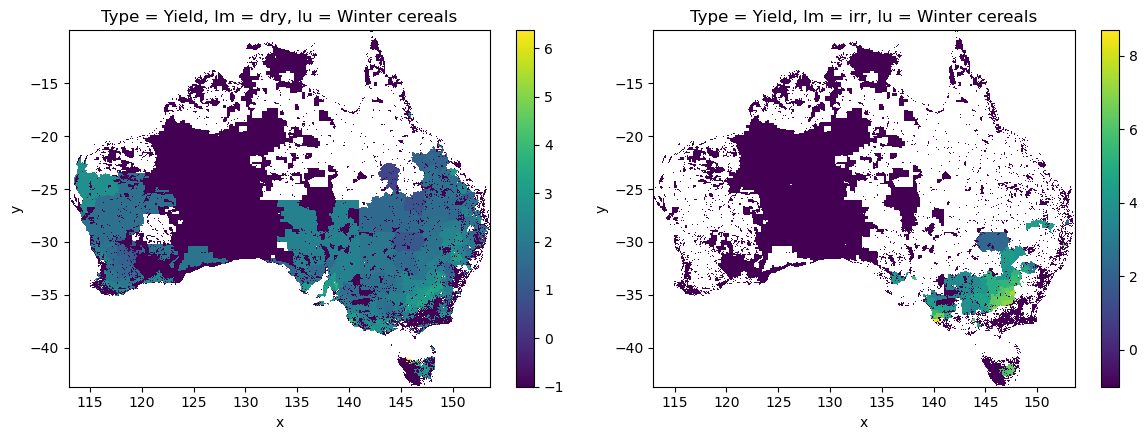

In [10]:
# Get the yield for the given land-use
p_dry = agec_crops_xr_lu.sel(Type='Yield', lm='dry').drop_vars('spatial_ref')
p_irr = agec_crops_xr_lu.sel(Type='Yield', lm='irr').drop_vars('spatial_ref')

plot_dry_irr(p_dry, p_irr)

## Climate change impacts

In [11]:
# Convert the `AGEC_CROPS` data to 2D xarray
cci_crops_xr = []
for col in data.CLIMATE_CHANGE_IMPACT.columns:
    series = data.CLIMATE_CHANGE_IMPACT[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'lm': [col[0]], 
        'lu': [col[1]], 
        'year': [col[2]]
    })
    cci_crops_xr.append(series_xr)

# Combine the xarray objects
cci_crops_xr = xr.combine_by_coords(cci_crops_xr)


# Append ones as the climate change impact in year 2010
cci_ones_dry = cci_crops_xr.sel(lm=['dry'], year=[2020])
cci_ones_dry.data = np.ones_like(cci_ones_dry.data)
cci_ones_dry.coords['year'] = [2010]
cci_ones_irr = cci_crops_xr.sel(lm=['irr'], year=[2020])
cci_ones_irr.data = np.ones_like(cci_ones_irr.data)
cci_ones_irr.coords['year'] = [2010]
cci_crops_xr = xr.combine_by_coords([cci_crops_xr, cci_ones_dry, cci_ones_irr])


# Get the data for the given land-use
cci_crops_xr_lu = cci_crops_xr.sel(lu=lu_desc)
# Linearly interpolate the data to 2010-2100
cci_crops_xr_lu = cci_crops_xr_lu.interp(year=range(2010, 2101), method='linear', kwargs={"fill_value": "extrapolate"})

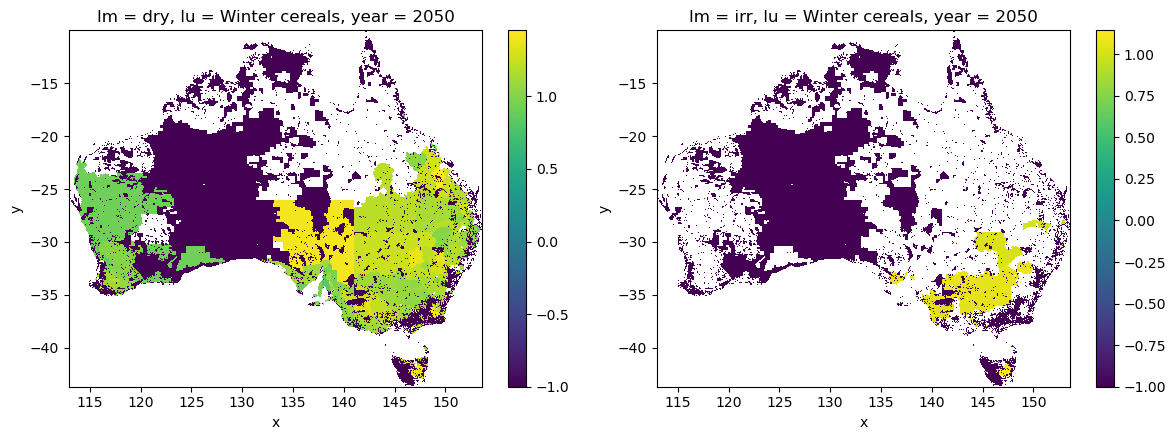

In [12]:
# Get the data for the given year
cci_dry = cci_crops_xr_lu.sel(lm='dry', year=year_target).drop_vars('spatial_ref')
cci_irr = cci_crops_xr_lu.sel(lm='irr', year=year_target).drop_vars('spatial_ref')

plot_dry_irr(cci_dry, cci_irr)

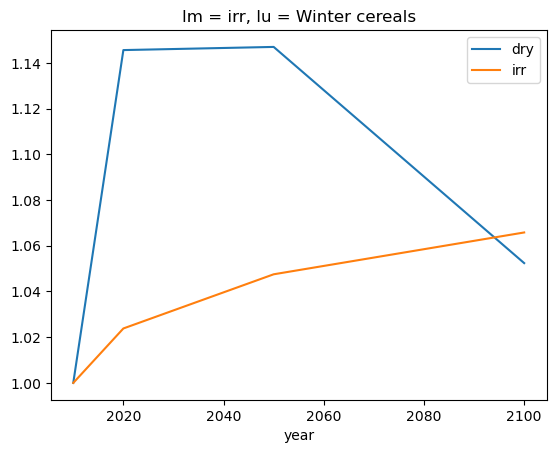

In [13]:
cci_crops_xr_lu_mean = (cci_crops_xr_lu * lu_mask.where(lu_mask == 1)).mean(dim=['x','y']) 
cci_dry_mean = cci_crops_xr_lu_mean.sel(lm='dry').drop_vars('spatial_ref')
cci_irr_mean = cci_crops_xr_lu_mean.sel(lm='irr').drop_vars('spatial_ref')


cci_dry_mean.plot()
cci_irr_mean.plot()
plt.legend(['dry', 'irr'])

## Commodity production 

In [14]:
# HIDDEN

mrp_xr =[]
for year in [year_begin, year_target]:
    yr_idx = year - year_begin
    # Get the quantity matrices
    q_mrp = get_quantity_matrices(data, yr_idx).astype(np.float32)          # t/cell
    q_mrp_xr = mrj_to_xr(data, q_mrp).expand_dims({'year': [year]})
    mrp_xr.append(q_mrp_xr)
    
# Combine the xarray objects
mrp_xr = xr.combine_by_coords(mrp_xr)                                       # t/cell                        

In [15]:
# Calculate the total quantity for each water supply
q_dry_begin = mrp_xr.sel(lm='dry', year=year_begin, lu=lu_desc.upper()).drop_vars('spatial_ref')
q_irr_begin = mrp_xr.sel(lm='irr', year=year_begin, lu=lu_desc.upper()).drop_vars('spatial_ref')

q_dry_total = lu_arr_dry.values * q_dry_begin.values       
q_dry_total = np.nansum(q_dry_total) / 1e6          # million t               

q_irr_total = lu_arr_irr.values * q_irr_begin.values     
q_irr_total = np.nansum(q_irr_total) / 1e6          # million t 

# Get the total quantity for the given land-use
q_total = q_dry_total + q_irr_total                 # million t       

print(f'Total quantity for {lu_desc} in {year_begin}: {q_total:.2f} million tonnes.') 

Total quantity for Winter cereals in 2010: 41.27 million tonnes.


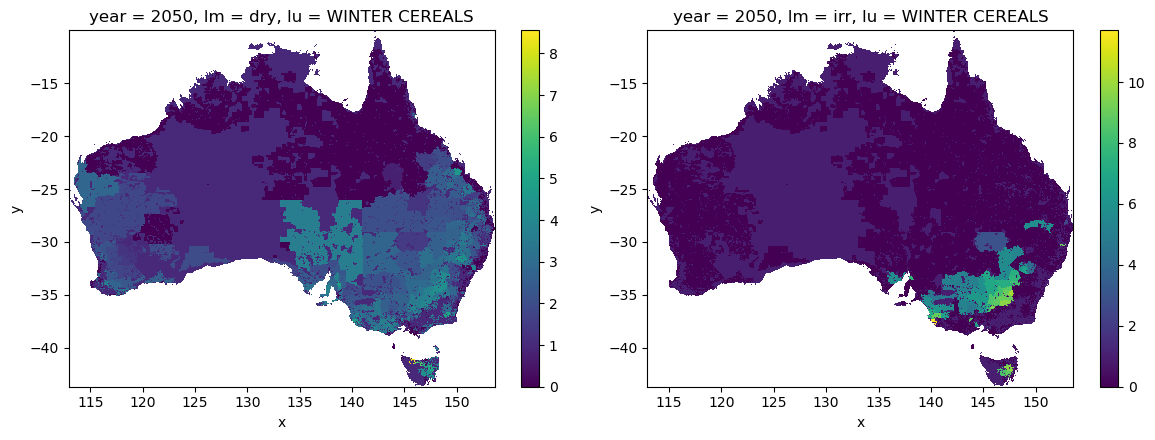

In [16]:
# HIDDEN
q_lu_target = mrp_xr.sel(year=year_target, lu=lu_desc.upper()) / lu_area  # t/ha

q_dry_target = q_lu_target.sel(lm='dry').drop_vars('spatial_ref')
q_irr_target = q_lu_target.sel(lm='irr').drop_vars('spatial_ref')
plot_dry_irr(q_dry_target, q_irr_target)

## Water Requirement

In [17]:
wr_mrj = get_wreq_matrices(data, year_target - year_begin)           # ML/cell
wr_mrj_xr = mrj_to_xr(data, w_mrj) / lu_area * lu_mask               # ML/ha

wr_mrj_xr_lu = wr_mrj_xr.sel(lu=lu_desc)

NameError: name 'w_mrj' is not defined

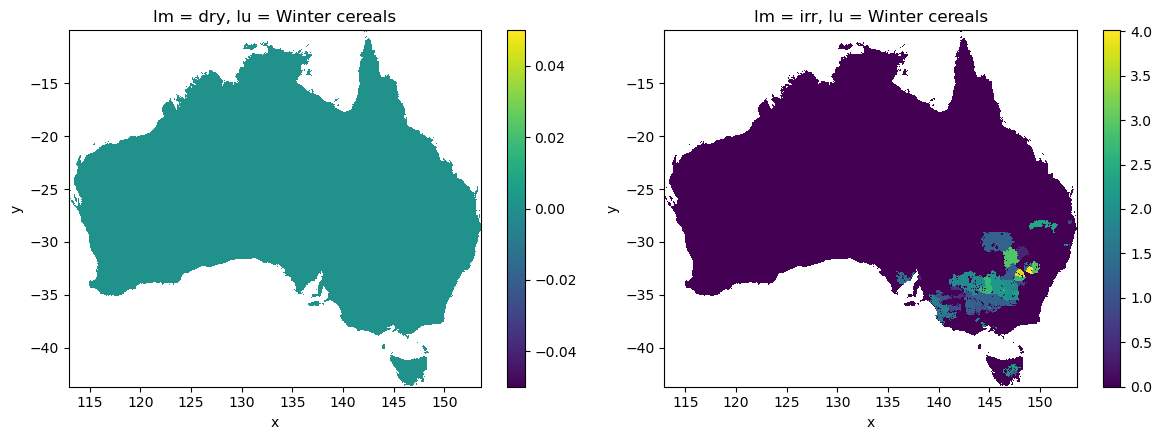

In [ ]:
wr_dry = wr_mrj_xr_lu.sel(lm='dry').drop_vars('spatial_ref')
wr_irr = wr_mrj_xr_lu.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(wr_dry, wr_irr)

## Costs and Revenues

In [ ]:
# Area Cost, Fixed Depreciation Cost, Fixed Labour Cost, Fixed Operating Cost   
c_fix = agec_crops_xr_lu.sel(Type=['AC', 'FDC', 'FLC', 'FOC'])       # $/ha

# Quantity Cost
c_q = agec_crops_xr_lu.sel(Type='QC') * q_lu_target                  # $/ha

# Water Cost
c_wr = agec_crops_xr_lu.sel(Type='WP') * wr_mrj_xr_lu                # $/ha          

# Revenue
r = agec_crops_xr_lu.sel(Type='P1') * q_lu_target                    # $/ha   


###########    Total Cost    ###########
c_total = c_fix.sum(dim='Type') + c_q + c_wr                         # $/ha  

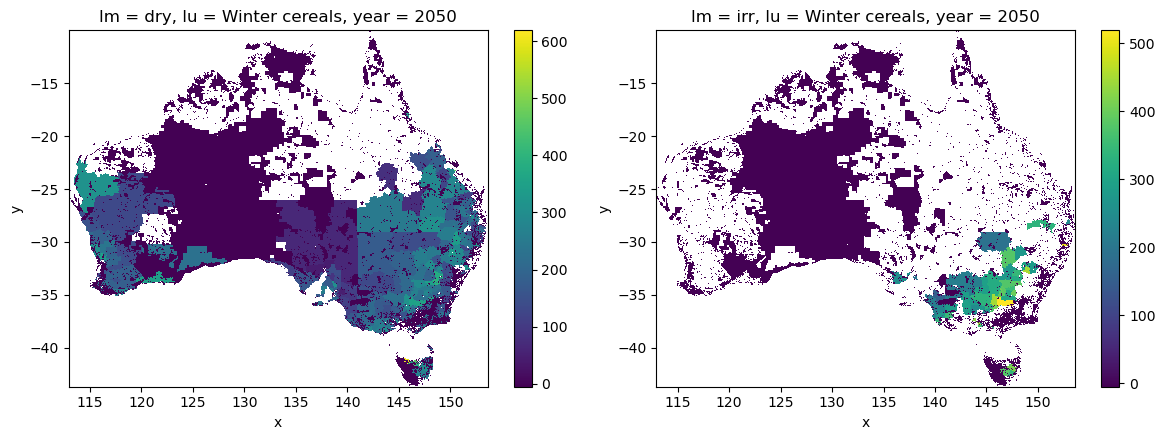

In [ ]:
c_arr = c_total

# HIDDEN
c_dry = c_arr.sel(lm='dry').drop_vars('spatial_ref')
c_irr = c_arr.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(c_dry, c_irr)

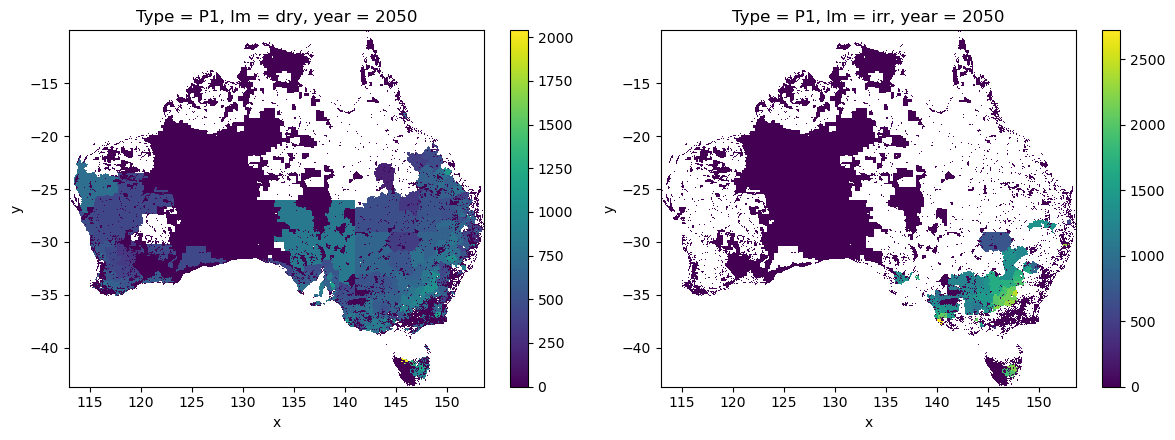

In [ ]:
# HIDDEN

r_dry = r.sel(lm='dry').drop_vars('spatial_ref')
r_irr = r.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(r_dry, r_irr)

## GHG emmisions

In [ ]:
# Convert the `AGEC_CROPS` data to 2D xarray
agghg_crops_xr = []
for col in data.AGGHG_CROPS.columns:
    series = data.AGGHG_CROPS[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'Type': [col[0]], 
        'lm': [col[1]], 
        'lu': [col[2]]
    })
    agghg_crops_xr.append(series_xr)

# Combine the xarray objects
agghg_crops_xr = xr.combine_by_coords(agghg_crops_xr)            # kg/ha

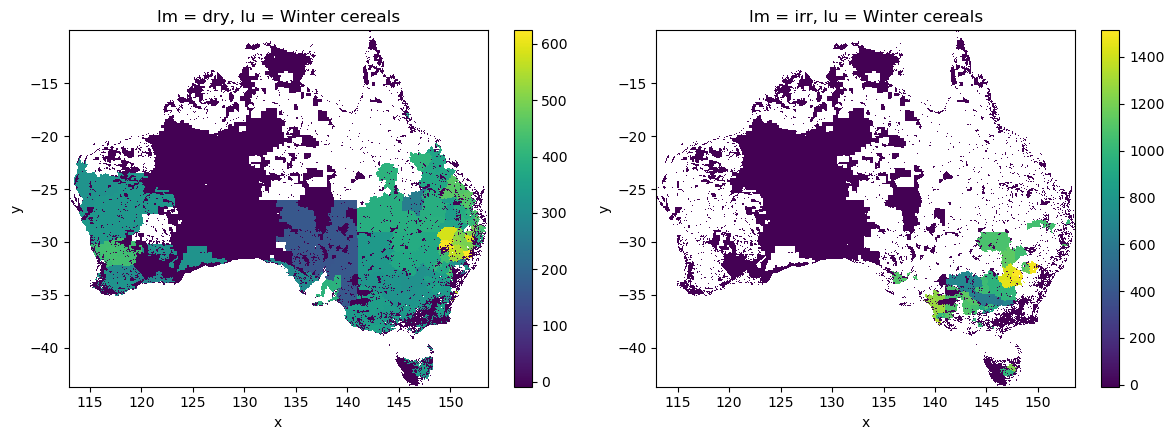

In [ ]:
# HIDDEN
agghg_crops_xr_lu = agghg_crops_xr.sel(lu=lu_desc).sum(dim=['Type'], skipna=False)    # kg/ha
ghg_dry = agghg_crops_xr_lu.sel(lm='dry').drop_vars('spatial_ref') 
ghg_irr = agghg_crops_xr_lu.sel(lm='irr').drop_vars('spatial_ref') 

plot_dry_irr(ghg_dry, ghg_irr)

## Find the optimized solution

In [ ]:
# Get the available land for the given land-use
lu_arr_dry_aval = (lu_arr_dry == 0) * (lu_arr_irr != 1) * (q_dry_target > 0)
lu_arr_irr_aval = (lu_arr_irr == 0) * (lu_arr_dry != 1) * (q_irr_target > 0)

In [ ]:
def rand_reduce_gap(in_dry, in_irr, q_dry, q_irr, gap, chunk_size=10):

    # Get the row/col for the non-zero values
    row_dry, col_dry = np.nonzero(in_dry)
    row_irr, col_irr = np.nonzero(in_irr)

    # Get the index for the non-zero values
    idx_dry = list(range(len(row_dry)))
    idx_irr = list(range(len(row_irr)))
    
    # Initialize the selected index
    sel_idx_dry = []
    sel_idx_irr = []
    
    # Loop until the gap is closed
    while gap>= 0:
        if len(idx_dry) <= chunk_size or len(idx_irr) <= chunk_size:
            print('Not enought land for the meeting the production gap.')
            break
        
        sel_dry = np.random.choice(idx_dry, chunk_size, replace=False)
        sel_irr = np.random.choice(idx_irr, chunk_size, replace=False)
        
        [idx_dry.remove(i) for i in sel_dry]
        [idx_irr.remove(i) for i in sel_irr]
        
        sel_idx_dry.extend(sel_dry)
        sel_idx_irr.extend(sel_irr)
        
        gap -= np.nansum(q_dry.values[row_dry.values[sel_dry], col_dry.values[sel_dry]])
        gap -= np.nansum(q_irr.values[row_irr.values[sel_irr], col_irr.values[sel_irr]])
        
    # Get the pred array
    pred_arr_dry = lu_arr_dry.copy()
    pred_arr_irr = lu_arr_irr.copy()
    
    pred_arr_dry.values[row_dry.values[sel_idx_dry], col_dry.values[sel_idx_dry]] = 2
    pred_arr_irr.values[row_irr.values[sel_idx_irr], col_irr.values[sel_idx_irr]] = 2
           
    return pred_arr_dry, pred_arr_irr

In [ ]:
# Randomly select from available land to meet the production gap
from joblib import Parallel, delayed 
from tqdm.auto import tqdm  

n_runs = 100     

gap = (demand_vol - q_total) * 1e6              # tonnes
q_dry_cell = q_dry_target * lu_area             # t/cell
q_irr_cell = q_irr_target * lu_area             # t/cell

para_obj = Parallel(n_jobs=20, return_as='generator')
tasks = (delayed(rand_reduce_gap)(lu_arr_dry_aval, lu_arr_irr_aval, q_dry_cell, q_irr_cell, gap, chunk_size=10) for _ in range(n_runs))
results = [i for i in tqdm(para_obj(tasks), total=n_runs)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Combine all results to one xarray object
pred_arr_xr = []
for i,arr in enumerate(results):
    dry_arr = arr[0].expand_dims({'run': [i], 'lm':['dry']},)
    irr_arr = arr[1].expand_dims({'run': [i], 'lm':['irr']},)
    pred_arr_xr.append(dry_arr)
    pred_arr_xr.append(irr_arr)

# Combine the xarray objects
pred_arr_xr = xr.combine_by_coords(pred_arr_xr)   

In [ ]:
c_pred_xr = c_total * lu_area * pred_arr_xr
c_pred_xr_sum = c_pred_xr.sum(dim=['lm','x', 'y']) / 1e9        # billion $

r_pred_xr = r * lu_area * pred_arr_xr
r_pred_xr_sum = r_pred_xr.sum(dim=['lm','x', 'y']) / 1e9        # billion $

wr_pred_xr = wr_mrj_xr_lu * lu_area * pred_arr_xr               
wr_pred_xr_sum = wr_pred_xr.sum(dim=['lm','x', 'y']) / 1e6      # million ML

ghg_pred_xr = agghg_crops_xr_lu * lu_area * pred_arr_xr         
ghg_pred_xr_sum = ghg_pred_xr.sum(dim=['lm','x', 'y']) / 1e9    # million t

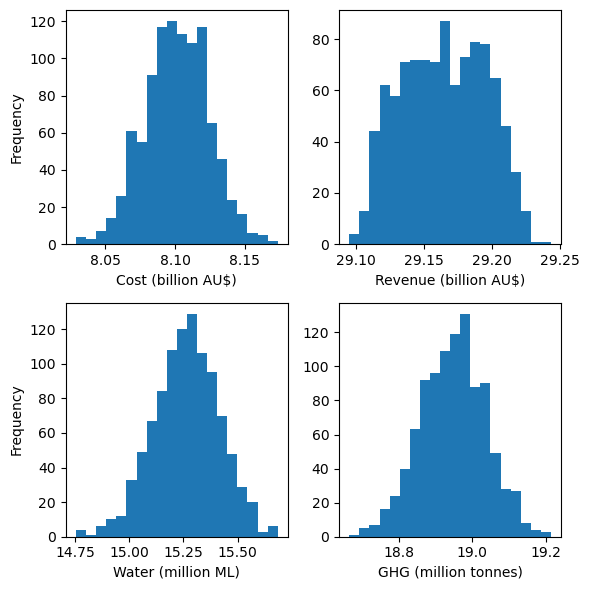

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()


axs[0].set_ylabel('Frequency')
axs[0].hist(c_pred_xr_sum, bins=20)
axs[0].set_xlabel('Cost (billion AU$)')

axs[1].hist(r_pred_xr_sum, bins=20)
axs[1].set_xlabel('Revenue (billion AU$)')

axs[2].set_ylabel('Frequency')
axs[2].hist(wr_pred_xr_sum, bins=20)
axs[2].set_xlabel('Water (million ML)')

axs[3].hist(ghg_pred_xr_sum, bins=20)
axs[3].set_xlabel('GHG (million tonnes)')


plt.tight_layout()

In [ ]:
# Set abitrairy water and GHG limits
ghg_lmt = 18.8           # million tonnes
water_lmt = 15           # million ML

runs_lmt = (ghg_pred_xr_sum < ghg_lmt) & (wr_pred_xr_sum < water_lmt)
runs_idx = ghg_pred_xr_sum.coords['run'].values[runs_lmt.values]

In [ ]:
c_df = c_pred_xr_sum[runs_idx].to_dataframe(name='Cost_billion_AUD').reset_index()
r_df = r_pred_xr_sum[runs_idx].to_dataframe(name='Revenue_billion_AUD').reset_index()

c_r_df = pd.merge(c_df, r_df, on=['run'], how='inner')[['run', 'Cost_billion_AUD', 'Revenue_billion_AUD']]
c_r_df['Profit_billion_AUD'] = c_r_df['Revenue_billion_AUD'] - c_r_df['Cost_billion_AUD']
c_r_df

,run,Cost_billion_AUD,Revenue_billion_AUD,Profit_billion_AUD
0,24,8.0678,29.1032,21.0354
1,171,8.0832,29.1643,21.0810
2,178,8.0811,29.1487,21.0676
3,188,8.0994,29.2217,21.1223
4,194,8.0613,29.1081,21.0468
5,259,8.0566,29.1517,21.0951
6,444,8.0318,29.1178,21.0861
7,458,8.0938,29.1129,21.0192
8,511,8.0979,29.1123,21.0143
9,687,8.0497,29.1230,21.0733


In [ ]:
c_min_idx = c_r_df['Cost_billion_AUD'].argmin()
c_min_run = c_r_df['run'][c_min_idx]

p_max_idx = c_r_df['Profit_billion_AUD'].argmax()
p_max_run = c_r_df['run'][p_max_idx]

print(f'The run with the minimum cost is {c_min_run}.\nThe run with the maximum profit is {p_max_run}.')

The run with the minimum cost is 444.
The run with the maximum profit is 188.


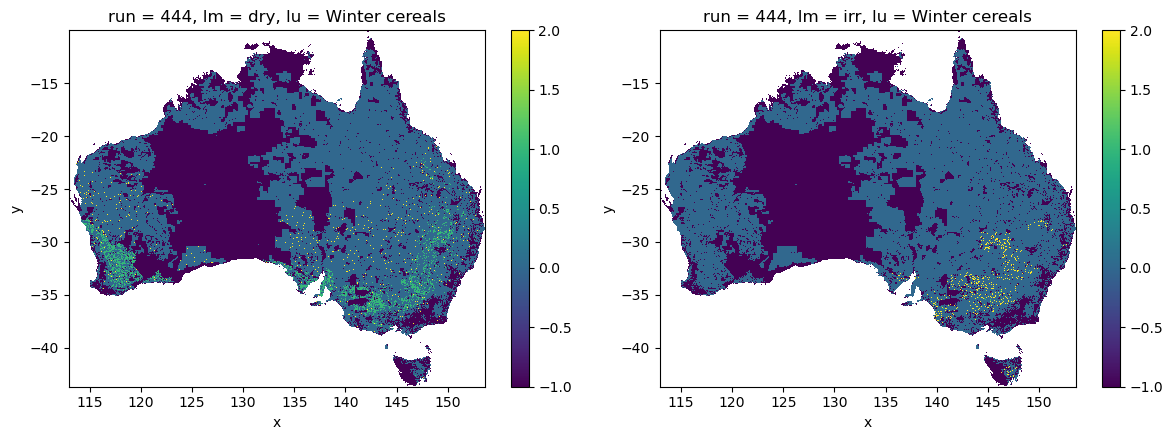

In [ ]:
pred_min_c = pred_arr_xr.sel(run=c_min_run)
pred_min_c_dry = pred_min_c.sel(lm='dry').drop_vars('spatial_ref')
pred_min_c_irr = pred_min_c.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(pred_min_c_dry, pred_min_c_irr)

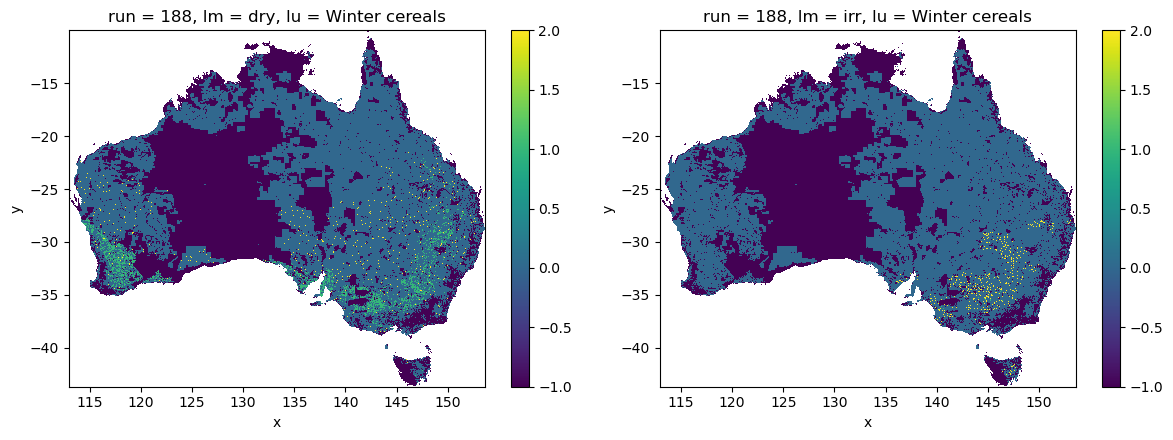

In [ ]:
pred_max_p = pred_arr_xr.sel(run=p_max_run)
pred_max_p_dry = pred_max_p.sel(lm='dry').drop_vars('spatial_ref')
pred_max_p_irr = pred_max_p.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(pred_max_p_dry, pred_max_p_irr)